# Geostatistics

## 7. Kriging

This final lecture introduces the concept of *kriging*. It can be used to estimate a variable at unobserved locations from the spatial structure of observations. We will cover:

* basic concept of Kriging
* implement a kriging algorithm
* introduce more advanced kriging methods

In [1]:
%matplotlib inline

In [82]:
import numpy as np
import pandas as pd
import skgstat as skg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import inv

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LinearColorMapper

output_notebook()

Loading BokehJS ...

## 7.1 What is Kriging?

Kriging is an **interpolation** method. We use it to **estimate** a value at an unobserved location. 

It is often referred to as a **BLUE** method.

* **B**est **L**inear **U**nbiased **E**stimator

We will go for each letter to better understand the method

In class, only one variant of Kriging will be presentend in detail: **Ordinary Kriging**. On top, we will introduce **Simple Updating Kriging** in the next block as one example of other Kriging methods.

Other commonly used methods include:

* Simple Kriging
* Universal Kriging
* External Drift Kriging
* Indicator Kriging
* Simple Updateing Kriging

### 7.1.1 Estimator

Kriging is an **estimation** method. 

**Estimation** always implies **uncertainty**. Thus, the method does not yield any kind of deterministic result imanent to the data, but an estimation that largely depends on the *variogram*. 

Recall, that the variogram is a 2nd order statistical moment of a multivariate spatial data **sample**. Like any other means of statistics, it therefore largely depends on the sample size. Any amount of uncertainty about statistical properties of the population is therefore transferred into the Kriging method and ultimately into the interpolation result.

Thus, trash in => trash out.

If your varigram is not describing the spatial structure of the data sample properly the interpolation will be uncertain. 

### 7.1.2 Linear

Next, let's understand what **linear** means in the context of Kriging.

Linear means that the estimation of a variable at an unobsorved location is the **linear combination** of $N$ neighboring locations' observation.

$$ Z^*(s_0) = \sum_{i=1}^N \lambda_i * Z(s_i) $$

Where $Z^*(s_0)$ is the estimation at $s_0$ and $s_1, s_2, \ldots, s_N$ are the neighbors. $\lambda$ are the weights that we need to *combine* the observations.

Recall the excursus to IDW. You know this already. IDW and Kriging use exactly the same combination to come up with an interpolation result. 

The only difference is how $\lambda$ is determined.

**IDW:** we defined a static rule, how we expect $lamda$ to depend on distance

**Kriging:** We use the variogram to depend a measure of *dissimilarity* on the distance

To complement **BLUE**: We try to find the **best**, **unbiased** set of weights.


### 7.1.3 Best

How can we find the **best** *estimation*?

* with *estimation* we already granted that the final interpolation value might be off the *real* value. 

* Think statistically: The value we estimate is just the **expected** value of the distribution of **possible** values to solve our interpolation problem. But we need a second parameter to describe a distribution.

* The **variance** of the distribution (of possible solutions) indicates how *far off* they might be with respect to the expected value

* to obtain the **best** estimation, we have to **minimize this variance**.

With this, we can assure that while we might not be able to precisely recalculate a value, we will at least **as close as possible**, given the data sample.

We define the deviation, or error, of the estimation to the true value as:

$$ \epsilon (s_0) = Z^*(s_0) - Z(s_0) $$

from which follows that:

$$ \epsilon(s_0) = \sum_{i=1}^N \lambda_i * (Z^*(s_0) - Z(s_0)) $$

and finally we want to minimize the variance of $\epsilon$ using the equation above to build a **linear** system of equations to solve for all $\lambda$.

$$ min(\sigma^2(\epsilon)) $$ 

however, we want to do that **unbiased**.

### 7.1.4 Unbiased

One of the fundamental assumptions of geostatistics, especially when we want to apply *Ordinary Kriging* is that the *intrinsic hypothesis* holds for the random field. 

In other words: The expected value of the random field has to be the same everywhere.

$$ E(Z(x_0)) = E(Z(x_i)) $$

and therefore we expect:

$$ E(\epsilon(x_0)) = 0 $$

Looking at the equation from earlier:

$$ E(\epsilon(s_0)) = E\left(\sum_{i=1}^N \lambda_i * (Z^*(s_0) - Z(s_0))\right) = 0$$

Which can only be solved independed from location if:

$$ \sum_{i=1}^N \lambda_i = 1 $$


Combining this all together gives the **Kriging equation system**:

$$ 
\begin{pmatrix}
\gamma(s_1,s_1) & \gamma(s_1, s_2) & \ldots & \gamma(s_1, s_N) & 1 \\
\gamma(s_2,s_1) & \gamma(s_2, s_2) & \ldots & \gamma(s_2, s_N) & 1 \\
\vdots & \ldots & \ddots & \vdots & 1 \\
\gamma(s_N,s_1) & \gamma(s_N, s_2) & \ldots & \gamma(s_N, s_N) & 1 \\
1 & 1 & \ldots & 1 & 0 \\
\end{pmatrix} * 
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_N \\
\mu
\end{bmatrix} = 
\begin{bmatrix}
\gamma(s_1, s_0) \\
\gamma(s_2, s_0) \\
\vdots \\
\gamma(s_N, s_0) \\ 
1
\end{bmatrix}
$$

We can also assign letters to these matrices like:

$$ \boldsymbol{A} * \boldsymbol{\omega} = \boldsymbol{b} $$ 

And finally we can solve for $\omega$ using the dot-product of $b$ and the inverse of $A$:

$$ \boldsymbol{\omega} = \boldsymbol{A^{-1}} \cdot \boldsymbol{b} $$

Finally the first $N$ entries in $\omega$ are $\lambda_1, \lambda_2, \ldots, \lambda_N$ and the last element is the lagrangian multiplier $\mu$ that was needed to met unbiasedness.

## 7.2 Estimating the variogram

We will use the variogram of the data sample used in the last lectures as our main means to determine the Kriging weights. Therefore, we need to re-calculate, exactly like in the past lectures.

In [3]:
coords = pd.read_csv('./data/sample_positions.txt', sep='\s+', header=None)
coords.columns = ['x', 'y']
data = pd.read_csv('./data/sample_data.txt', sep='\s+')
sample = coords.copy()
sample['z'] = data.loc[0, :].values

The same data sample will be used:

In [4]:
sample.head()

,x,y,z
0,22,78,-0.203508
1,3,73,-0.164411
2,12,85,-0.696673
3,9,69,-0.555673
4,78,43,1.286489


Like in the previous lectures we need to compile 

* an array of row-wise sorted pairwise distancs
* an array of row-wise sorted pairwise observation - differences
* an array of upper limits for binning the distances
* an array of row-wise sorted grouping indices to order the differences into lag bins


From that we can calculate the experimental variogram and finally fit a model to it. For the sake of simplicity, we use `scikit-gstat` again.

In [5]:
V = skg.Variogram(
    sample[['x', 'y']].values,      # x,y coordinates
    sample.z.values,                # observations
    maxlag=100,                     # maximum search distance to form pairs
    n_lags=8,                       # number of bins
    model='gaussian',               # theoretical model
    fit_sigma=[.33, .33, .33, 1., 1., 1., 1., 1.]   # give 3x weight to first three bins
)

Instead of building all the figures again, we can also use the `Variogram.plot` method, that is readily available:

/home/mirko/Dropbox/python/scikit-gstat/skgstat/Variogram.py:1645: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


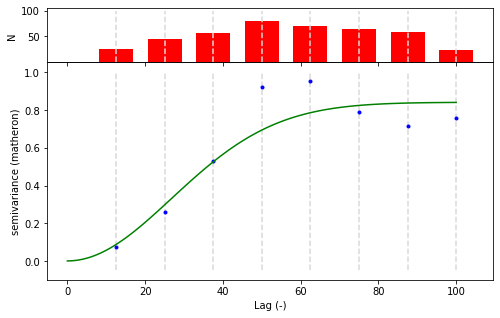

In [6]:
fig = V.plot()

In [7]:
print(V)

gaussian Variogram
------------------
Estimator:         matheron
Effective Range:   75.78
Sill:              0.84
Nugget:            0.00
        


Remember, if we want to back-calculate the range *parameter* $a$, we have to use the formula:

$$ a = \frac{r}{3} $$

In [8]:
print('Range parameter:', round(V.describe()['effective_range'] / 3., 2))

Range parameter: 25.26


Finally, the `Variogram` can return a parameterized model function that we can use to model the semi-variance at any distance:

In [9]:
model = V.fitted_model

In [10]:
print('y(75.78) =', model(75.78))
print('y(10.)   =', model(10.))
print('y(50.)   =', model(50.))
print('y(10000) =', model(10000))

y(75.78) = 0.8261676037188848
y(10.)   = 0.05662390401131155
y(50.)   = 0.6940638750687906
y(10000) = 0.8415832887003124


Now, we are prepared to calculate the estimation at `(44, 56)`.

## 7.3 Implementation for one point

To compare, we will stick to the example used in the IDW excursus and make an estimation for the same location $s_0 = (44, 56)$.

We expect to get a similar value here, as the are is well covered by other point. This makes IDW usually quite robust.

First, we need a distance array for our point of interest to all other points. We can access the distance function used by the variogram class as `Variogram.dist_function`. This is extremely useful, in case we used another measure for distance.

In [11]:
poi = (44, 56)

# bit of Python list wrangling
poi_sample = list(zip(*[[poi[0]] + list(sample.x.values), [poi[1]] + list(sample.y.values)]))

I created a a list `poi_sample` containing the point of interest as first element. Then the first $N$ elements give the distances to the sample

In [12]:
poi_dist = V.dist_function(poi_sample)[:len(sample)]
print(poi_dist.round(2))

[31.11 44.38 43.19 37.34 36.4  50.09  9.85 38.47 63.13  6.08 28.16 53.24
 43.38 42.45 24.19 46.24 36.25 43.14 42.45 41.05 61.85 37.48 40.61 30.89
 21.1  55.23 41.77 37.58 40.36 27.02]


### 7.3.1 Find neighbors

How many neighbors should we include? 

* In IDW we simply used all points, because there were not too many combinations. Max. of 29 observations were combined into the prediction
* For Kriging this is not useful. Why?

For each neighbor we add to the estimation, the kriging matrix $\boldsymbol{A}$ is increasing by **one row and one column**.

Look to the variogram: Up to which distance to we **expect** another observation to bear **predictive information** about $s_0$?

That is basically the definition of the **effective range**: Up to this distance we expect (and model!) a spatial dependency between observation. Above that distance, we **expect the observations to be statistically independent**.

In [13]:
all([d < 75.78 for d in poi_dist])

True

**But**, we do not calculate the mean of $\gamma$, we use $\gamma$ to derive the weights $\lambda$ to calculate the weighted mean of $Z$. 

Think of a weight like this as the inverse of semi-variance. It will drop dramatically with distance.

In the next figure, the weights were *approximated* for the given point. Actual weights mights vary a little bit:

In [14]:
dep = figure(width=500, height=500, x_axis_label='h', y_axis_label='w')

# **approximate** the weights
w = inv(V.distance_matrix).dot(poi_dist)

dep.scatter(poi_dist, w, marker='square', size=9, legend_label='approx. weights')

GlyphRenderer(id='1037', ...)

In [15]:
show(dep)

* You can see that the estimation will largely depend on only two close observations

* in the **presented example** using more than 6 neighbors for estimation does literally not make any differene

* remember that the plot above is bound to the example point of `(44, 56)` and will differ for other locations

* From experience we can tell that using more than `15` points does usually not make sense

My personal strategy is to:

* search inside the `effective range` for neighbors and limit the number to a (hyper-)parameter of `max_points=15`, which I usually not change.

* set another (hyper-)parameter of `min_points=3`. If less points are within the range, I estimate a `NaN`

* If many sample points are available (like > 200) I set `min_points=5`

* In case `15%` of all estimations end up with `NaN`, I do not trust the results. Quite often, this is because the `effective_range` is really small. Sometimes, the variogram can be adjusted.

In [16]:
sorted_index = np.argsort(poi_dist)
sorted_index

array([ 9,  6, 24, 14, 29, 10, 23,  0, 16,  4,  3, 21, 27,  7, 28, 22, 19,
       26, 13, 18, 17,  2, 12,  1, 15,  5, 11, 25, 20,  8])

The numpy function `argsort` will sort an array but return the **index** to sort the values.

In Octave, the `sort` function returns two objects: the sorted array and the sorted index:

```Matlab
[sorted, index] = sort(pot_dist)
```

In [17]:
neighbors = sample.iloc[sorted_index[:6], :]
neighbors

,x,y,z
9,43,50,0.763894
6,35,60,0.572388
24,62,45,1.840647
14,65,68,0.717486
29,23,73,-0.230938
10,52,83,-0.253400


## 7.4 Implementation for one point

### 7.4.1 Build the Kriging matrix

Finally, we got everything together to build the kriging matrix. We could either extract the distances for the selected observations from the (squareform) distance matrix, but as we go for only one point and use only 6 observations, we can also easily re-calculate the distances:

In [18]:
squareform(pdist(neighbors)).round(2)

array([[ 0.  , 12.81, 19.68, 28.43, 30.5 , 34.22],
       [12.81,  0.  , 30.91, 31.05, 17.71, 28.61],
       [19.68, 30.91,  0.  , 23.22, 48.06, 39.35],
       [28.43, 31.05, 23.22,  0.  , 42.31, 19.87],
       [30.5 , 17.71, 48.06, 42.31,  0.  , 30.68],
       [34.22, 28.61, 39.35, 19.87, 30.68,  0.  ]])

This is nothing new and as we have the `model` extracted and the distances as an array, it's easy to use semi-variances instead of distances:

In [19]:
_co = squareform([model(d) for d in pdist(neighbors)])
_co.round(2)

array([[0.  , 0.09, 0.2 , 0.36, 0.4 , 0.47],
       [0.09, 0.  , 0.41, 0.41, 0.17, 0.37],
       [0.2 , 0.41, 0.  , 0.26, 0.67, 0.56],
       [0.36, 0.41, 0.26, 0.  , 0.6 , 0.2 ],
       [0.4 , 0.17, 0.67, 0.6 , 0.  , 0.4 ],
       [0.47, 0.37, 0.56, 0.2 , 0.4 , 0.  ]])

The next step is easy to follow, but usually needs a more or less complicated implementation in the language you are using.

We need to append a row and a column of `1` and set the most right lowest value to `0`. In any C-like language (which Python here ultimately is as we use numpy and also Matlab relies ultimately on it) we usually cannot just *add* an element. 

In [20]:
np.vstack((_co, np.ones(6).T)).round(2)

array([[0.  , 0.09, 0.2 , 0.36, 0.4 , 0.47],
       [0.09, 0.  , 0.41, 0.41, 0.17, 0.37],
       [0.2 , 0.41, 0.  , 0.26, 0.67, 0.56],
       [0.36, 0.41, 0.26, 0.  , 0.6 , 0.2 ],
       [0.4 , 0.17, 0.67, 0.6 , 0.  , 0.4 ],
       [0.47, 0.37, 0.56, 0.2 , 0.4 , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]])

In Python, we can do the same for the column, by transposing the matrix, stack the row and transpose again. This is easy and fast, because, the array is just indexed differently not really sorted.

In [21]:
_co2 = np.vstack((_co, np.ones(6).T))
A = np.vstack((_co2.T, np.ones(7).T)).T
A[-1, -1] = 0
A.round(2)

array([[0.  , 0.09, 0.2 , 0.36, 0.4 , 0.47, 1.  ],
       [0.09, 0.  , 0.41, 0.41, 0.17, 0.37, 1.  ],
       [0.2 , 0.41, 0.  , 0.26, 0.67, 0.56, 1.  ],
       [0.36, 0.41, 0.26, 0.  , 0.6 , 0.2 , 1.  ],
       [0.4 , 0.17, 0.67, 0.6 , 0.  , 0.4 , 1.  ],
       [0.47, 0.37, 0.56, 0.2 , 0.4 , 0.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  ]])

That was $\boldsymbol{A}$. Now we need b, which is can be calculated by mapping the model on `poi_dist` and appending a `1`:

In [22]:
# map the 
_g = list(map(model, poi_dist[sorted_index][:6]))
b = np.concatenate((_g, [1]))
b.T.round(2)

array([0.02, 0.05, 0.22, 0.28, 0.34, 0.36, 1.  ])

### 7.4.2 Solve

Now solve:

As introduced and described above, we will just use the `inv` function to inverse a matrix. I will not introduce the procedure how to invert a matrix. This should have been part of your maths classes in the Bachelor and beyond the scope of this lecture.

One thing that this step inplies is that the matrix $\boldsymbol{A}$ can actually be inverted. This is most often not the case if it's a singular matrix and your compiler will then tell you so.

In [23]:
result = inv(A).dot(b)
result.round(2)

array([ 0.37,  0.62,  0.07,  0.09, -0.17,  0.03, -0.03])

Again, Octave and Matlab use exactly the same function name.

Be careful with the different kind of matrix-multiplications:

In [24]:
(inv(A).dot(b) == inv(A) * b).all()

False

Python implements other algorithms and techniques to solve a system of linear equations. Most of them are available in either the `scipy.linalg` or `numpy.linalg` package. As a rule of thumb: The `scipy` versions usually run some tests on the input to raise more meaningful error messages. The `numpy` versions usually just include barebones math: faster but less verbose output on failure. In some functions you just always receive a `LinAlgError` if *anything* goes wrong.

### 7.4.3 Estimate

In [25]:
examp = sample.iloc[sorted_index[:6], :].copy()

# append the weight
examp['weight'] = result[:-1]

# append the weighted value
examp['weighted value'] = examp.z * examp.weight

examp

,x,y,z,weight,weighted value
9,43,50,0.763894,0.368508,0.281501
6,35,60,0.572388,0.615905,0.352537
24,62,45,1.840647,0.068159,0.125456
14,65,68,0.717486,0.086494,0.062058
29,23,73,-0.230938,-0.173967,0.040176
10,52,83,-0.253400,0.034902,-0.008844


In [26]:
print('Mean:', examp.z.mean().round(2))
examp[['weight', 'weighted value']].sum() 

Mean: 0.57


weight            1.000000
weighted value    0.852883
dtype: float64

*In a real implementation, you would of course calculate the estimation in one step. This was only for illustration purpose.*

Actually summing up the weights can be used to test during development. They **have to** sum up to one, with the exception of numerical deviations. Therefore you would usually test for the difference to a threshold:

In [27]:
abs(sum(result[:-1]) - 1.0) < 0.001

True

### 7.4.4 Kriging variance

One of the huge benefits of Kriging is, that once we calculated the weights we can also calculate the kriging variance from this. 

For this, we simply weight the semi-variances for the point of interest to the meighbors and add the lagrange parameter, we needed to solve the equation system.

$$ \sigma^2 = \sum_{i=1}^N \left(\lambda_i * \gamma(s_0, s_i)\right) + \mu $$

In [30]:
# I could be wrong here
sum(result[:-1] * b[:-1]) + result[-1] 

0.009498665588521929

Thus, finally we can predict at unobserved locations and make a statement about our **certainty** with this estimation.

## 7.5 Estimating a whole field

The last step is, just like for IDW, to automate the process and apply the algorithm to a set of unobserved locations. 

As the estimation at one point is independent of estimations at other location, this process can be highly parallelized. This can speed things up as modern laptops are capable of simultaneously execuing 8 or 16 processes. 

On cloud resources you can easily scale to literally hundresds of nodes at low cost.

We will also stick to the same parameter as with IDW, but to make things a bit clearer, we will first implement the kriging for one point into a function.

Furthermore, it is often very helpful to place the building (and solving) of the kriging matrix into yet another function. This is where some Kriging algorithms differ and where you can speed things up.
Also, if you run into errors, it's often wise to separate math and number wrangling.

Go for the matrix first:

In [60]:
def kriging_matrix(neighbors, variogram):
    m = variogram.fitted_model
    
    # inner part
    co = squareform([m(d) for d in variogram.dist_function(neighbors)])
    
    # lagrange stuff
    co = np.vstack((co, np.ones(len(neighbors)).T))
    A = np.vstack((co.T, np.ones(len(neighbors) + 1).T)).T
    A[-1, -1] = 0
    
    return A

def solve(A, b):
    # this is only to replace the solver without changing the algorithm
    return inv(A).dot(b)

In [102]:
def point_krige(poi, variogram, min_points=3, max_points=15):
    # calculate distance to neighbors
    poi_sample = list(zip(*[
        [poi[0]] + list(variogram.coordinates[:,0]), 
        [poi[1]] + list(variogram.coordinates[:,1])
    ]))
    poi_dist = V.dist_function(poi_sample)[:len(variogram.coordinates)]
    
    # find close neighbors
    sindex = np.argsort(poi_dist)[np.where(poi_dist < variogram.describe()['effective_range'])[0]]
    # check number
    if len(sindex) < min_points:
        return np.NaN, np.NaN
    if len(sindex) > max_points:
        sindex = sorted_index[:max_points]
    neighbors = variogram.coordinates[sindex]
    
    # build the matrix
    A = kriging_matrix(neighbors, variogram)
    b = [variogram.fitted_model(d) for d in poi_dist[sindex]] + [1]
    
    w = solve(A, b)
    
    assert abs(sum(w[:-1]) - 1.) < 0.001
    
    z = sum(w[:-1] * V.values[sindex])
    s = sum(w[:-1] * b[:-1]) + w[-1]
    
    return z, s

In [111]:
size = 2
ylim = (0, 100)
xlim = (0, 100)
kriged = []
sigma = []
min_points = 3
max_points = 15

# build a 'mesh'-grid
grid = [[(j,i) for j in range(xlim[0], xlim[1] + size, size)] for i in range(ylim[0], ylim[1] + size, size)]

for row in grid:
    krig_row = []
    sigma_row = []
    for cell in row:
        # implement stuff here-
        z, s = point_krige(cell, V, min_points=min_points, max_points=max_points)
        krig_row.append(z if not np.isnan(z) else None) # plotting workaround
        sigma_row.append(s if not np.isnan(s) else None)
    # append row
    kriged.append(krig_row)
    sigma.append(sigma_row)
    

In [208]:
source = ColumnDataSource(sample)
cmap = LinearColorMapper(palette='Viridis256', low=sample.z.min(), high=sample.z.max())

kriging = figure(
    title='Kriging interpolation', x_range=(0,100), y_range=(0,100), tools=['hover,box_zoom,reset'],
    tooltips=[('observation', '@z')]
)

kriging.image([kriged], x=0, y=0, dw=100, dh=100, color_mapper=cmap)
kriging.circle('x', 'y', source=source, size=12, line_color='white', fill_color={'field': 'z', 'transform': cmap})

GlyphRenderer(id='17811', ...)

In [209]:
show(kriging)

In [182]:
np.max(kriged), sample.z.max()

(2.496154050146142, 1.84064736801354)